# Example: Generate input arrays for PyRayHF
This example shows how the input arrays for PyRayHF can be generated with PyIRI

PyIRI is used to generate IRI electron density and IGRF magnetic field for each point along the vertical profile.

1. Import Libraries

In [1]:
import PyRayHF
import matplotlib.pyplot as plt
import numpy as np

2. PyIRI Input Conditions

In [2]:
# Select the day and Universal Time of interest
year = 2020
month = 4
day = 1
UT = 10.0

# F10.7 index for the selected day
F107 = 69.4


# Define geographic location (longitude, latitude in degrees)
lon = 10.0
lat = 0.0

# Create an array of altitudes (km)
aalt = np.arange(90., 600., 1.)

2. Generate and Save 1D Data

In [3]:
# Save to file
save_path = './Example_input.p'

# Generate 1D Data
input_example = PyRayHF.library.generate_input_1D(year, month, day, UT, lat, lon, aalt, F107, save_path=save_path)

`generate_input_1D()` returns a dictionary in the following format:

out_data : dict

- 'alt' : z coordinate array of vertical grid in km
- 'den' : Array of electron density in m^-3
- 'bmag' : Array of magnetic field strenth in T
- 'bpsi' : Array of magnetic field angle to vertical in degrees
- 'F2' : PyIRI output dictionary for F2 region at (tlon, xlat)
- 'F1' : PyIRI output dictionary for F1 region at (tlon, tlat)
- 'E' : PyIRI output dictionary for E region at (tlon, tlat)
- 'Es' : PyIRI output dictionary for Es region at (tlon, tlat)
- 'year' : Year used to run PyIRI for this data 
- 'month' : Month used to run PyIRI for this data 
- 'day' : Day of month used to run PyIRI for this data 
- 'UT' : Unniversal time used to run PyIRI for this data 
- 'F107' : F10.7 in SFU used to run PyIRI for this data
- 'tlat' : Latitude in degrees of transmitter
- 'tlon' : Longitude in degrees of transmitter

3. Plot 1D Data

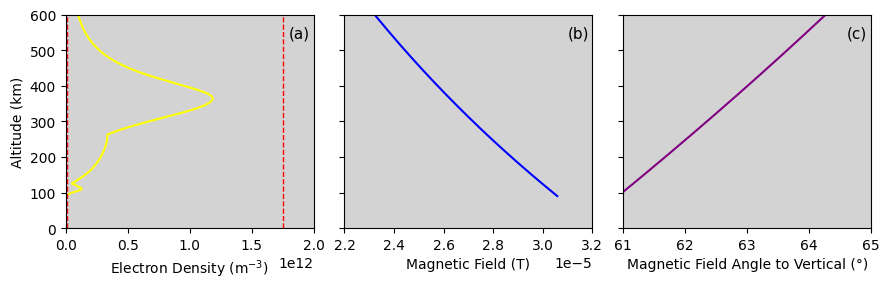

Lon 10°, Lat 0°, F10.7 69.4 SFU, 20200401 10UT


In [4]:
# Example Frequency Input
ionosonde_frequency = np.arange(1, 12, 0.1)

# Plot the input arrays
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 3)


# Plot electron density profile
ax_plot = ax[0]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([0, 2e12])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Electron Density (m$^{-3}$)')
ax_plot.plot(input_example['den'], input_example['alt'], c='yellow',
             label='EDP')
min_d = PyRayHF.library.freq2den(np.min(ionosonde_frequency) * 1e6)
max_d = PyRayHF.library.freq2den(np.max(ionosonde_frequency) * 1e6)
ax_plot.axvline(x=min_d, color='r', linestyle='--', linewidth=1, label='Instrument Freq Range')
ax_plot.axvline(x=max_d, color='r', linestyle='--', linewidth=1)
ax_plot.text(0.90, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot magnetic field magnitude
ax_plot = ax[1]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([2.2e-5, 3.2e-5])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field (T)')
ax_plot.plot(input_example['bmag'], input_example['alt'], c='blue',
             label='B')
ax_plot.text(0.90, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot angle between magnetic field and vertical
ax_plot = ax[2]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([61, 65])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field Angle to Vertical (°)')
ax_plot.plot(input_example['bpsi'], input_example['alt'], c='purple',
             label='$\\Psi$')
ax_plot.text(0.90, 0.95, '(c)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
plt.tight_layout()
plt.savefig('../figures/Input_Arrays.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

dtime_stamp = f"Lon 10°, Lat 0°, F10.7 69.4 SFU, {year}{month:02d}{day:02d} {int(UT):02d}UT"
print(dtime_stamp)